# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [7]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [8]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.describe()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [92]:
for column in azdias.columns.values:
    print(column + ":  "+ str(azdias[column].dtypes)+"  "+str(azdias[column].unique()))

AGER_TYP:  int64  [-1  2  3  0  1]
ALTERSKATEGORIE_GROB:  int64  [2 1 3 4 9]
ANREDE_KZ:  int64  [1 2]
CJT_GESAMTTYP:  float64  [  2.   5.   3.   4.   1.   6.  nan]
FINANZ_MINIMALIST:  int64  [3 1 4 2 5]
FINANZ_SPARER:  int64  [4 5 2 3 1]
FINANZ_VORSORGER:  int64  [3 2 1 5 4]
FINANZ_ANLEGER:  int64  [5 2 1 4 3]
FINANZ_UNAUFFAELLIGER:  int64  [5 4 3 1 2]
FINANZ_HAUSBAUER:  int64  [3 5 2 4 1]
FINANZTYP:  int64  [4 1 6 5 2 3]
GEBURTSJAHR:  int64  [   0 1996 1979 1957 1963 1943 1964 1974 1975 1941 1993 1946 1988 1991 1966
 1949 1982 1972 1990 1985 1989 1948 1935 1997 1994 1987 2002 1950 1965 1969
 1978 1958 1944 1967 1977 1960 1970 1973 1971 1937 1947 1926 1954 1981 1962
 1992 2008 1976 1928 1927 1968 1940 1952 1961 2006 1938 1945 1942 1984 1930
 1980 1959 1986 1931 1955 1983 2010 1951 1921 1929 1939 2001 1995 1956 1953
 2012 1934 1913 1914 1922 2004 1936 2009 1915 2003 2013 1998 2007 1932 2005
 1923 1925 2015 1933 2017 2000 1999 2014 1920 1918 1924 2016 2011 1908 1919
 1916 1917 1912 1911 

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [121]:
feat_info[feat_info["attribute"]=="ALTERSKATEGORIE_GROB"]

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"


In [161]:
feat_info["missing_or_unknown"].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [9]:
def count_missing_data(df):
    row_count=df.shape[0]
    row_list=[]
    for column in df.columns.values:
        row_list.append([column, round(df[column].isnull().values.sum()/row_count*100, 2)])
        #print(column + ":  " + str(round(df[column].isnull().values.sum()/row_count*100, 2))+ " %")
    missing_data_df=pd.DataFrame(row_list, columns=["feature", "nan [%]"])
    missing_data_df.sort_values("nan [%]", ascending=False, inplace=True)
    return missing_data_df

count_missing_data(azdias)

,feature,nan [%]
47,KK_KUNDENTYP,65.60
65,KBA05_GBZ,14.96
60,KBA05_ANTG1,14.96
62,KBA05_ANTG3,14.96
71,MOBI_REGIO,14.96
61,KBA05_ANTG2,14.96
63,KBA05_ANTG4,14.96
64,KBA05_BAUMAX,14.96
73,REGIOTYP,13.60
70,KKK,13.60


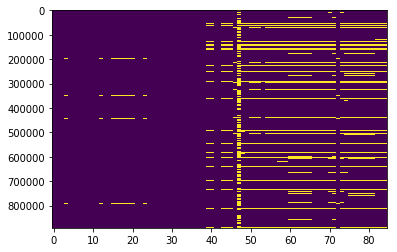

In [5]:
plt.imshow(azdias.isnull(), aspect='auto')
plt.show()

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.
import re

def get_miss_dict(df):
    #produces a dict containing the column name as key and the list of missing_or_unknown
    #values as values
    miss_dict={}
    for column in df.columns.values:
        miss_string_raw=feat_info.loc[feat_info["attribute"]==column]["missing_or_unknown"].values[0]
        miss_string=re.sub('\[|\]', '', miss_string_raw)
        miss_list=re.split(',', miss_string)
        #weed out empty strings
        if not "" in miss_list:
            if df[column].dtypes=="int64":
                miss_list=[int(a) for a in miss_list]
            elif df[column].dtypes=="float64":
                miss_list=[float(a) for a in miss_list]
                
        miss_dict[column]=miss_list
    
    return miss_dict

In [11]:
def replace_missing_values(df):
    miss_dict=get_miss_dict(df)
    df_new=pd.DataFrame()
    for column in df.columns.values:
        df_new[column]=df[column].replace(miss_dict[column], np.nan)
    return df_new

In [9]:
azdias_replaced=replace_missing_values(azdias)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([  0.   ,   9.976,  19.952,  29.928,  39.904,  49.88 ,  59.856,
         69.832,  79.808,  89.784,  99.76 ]),
 <a list of 10 Patch objects>)

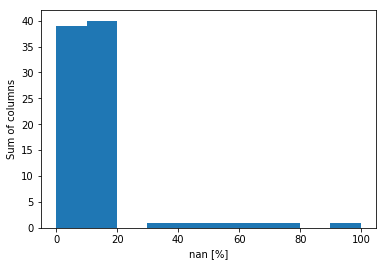

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data=count_missing_data(azdias_replaced)
plt.xlabel("nan [%]")
plt.ylabel("Sum of columns")
plt.hist(missing_data["nan [%]"])

In [10]:
missing_data.iloc[:20]

,feature,nan [%]
40,TITEL_KZ,99.76
0,AGER_TYP,76.96
47,KK_KUNDENTYP,65.60
64,KBA05_BAUMAX,53.47
11,GEBURTSJAHR,44.02
43,ALTER_HH,34.81
70,KKK,17.74
73,REGIOTYP,17.74
48,W_KEIT_KIND_HH,16.61
60,KBA05_ANTG1,14.96


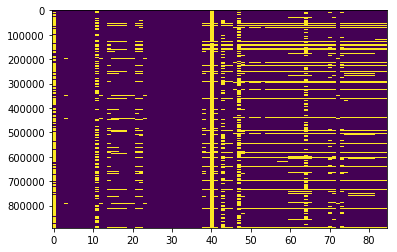

In [10]:
# Investigate patterns in the amount of missing data in each column.
plt.imshow(azdias_replaced.isnull(), aspect='auto')
plt.show()

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
high_nan_list=missing_data[missing_data["nan [%]"]>30]["feature"].values.tolist()
azdias_columns_dropped=azdias_replaced.drop(high_nan_list, axis=1)

#### Discussion 1.1.2: Assess Missing Data in Each Column
There where six columns with a percentage of missing values higher than 30%, those were:

'TITEL_KZ',

'AGER_TYP',

'KK_KUNDENTYP',

'KBA05_BAUMAX',

'GEBURTSJAHR',

'ALTER_HH'


and many other columns with up to 20% of the data missing.
While the former were dropped, the latter were kept, as it seems like there seem to be patterns for the missing data. Those could be read from both the similar percentages of missing data, as well as the imshow plot, indicating, that a sizable number of data might be missing row wise.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

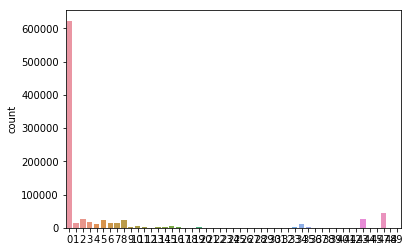

In [12]:
# How much data is missing in each row of the dataset?
sns.countplot(azdias_columns_dropped.isnull().sum(axis=1))

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_nan_rows=azdias_columns_dropped[azdias_columns_dropped.isnull().sum(axis=1)>8]
azdias_no_nan_rows=azdias_columns_dropped[azdias_columns_dropped.isnull().sum(axis=1)<9]

In [16]:
print("Percentage of rows with less than nine missing values: "+ str(round(azdias_no_nan_rows.shape[0]/azdias_columns_dropped.shape[0]*100,2))+" %")
print("Percentage of rows with more than nine missing values: "+ str(round(azdias_nan_rows.shape[0]/azdias_columns_dropped.shape[0]*100,2))+" %")

between_one_and_eight=azdias_columns_dropped[(azdias_columns_dropped.isnull().sum(axis=1)<9)&(azdias_columns_dropped.isnull().sum(axis=1)>0)].shape[0]
more_than_eight=azdias_columns_dropped[azdias_columns_dropped.isnull().sum(axis=1)>8].shape[0]
print("Percentage of rows with up to eight missing values: "+ str(round(between_one_and_eight/azdias_columns_dropped.shape[0]*100,2))+" %")
print("Percentage of rows with more than eight missing values: "+ str(round(more_than_eight/azdias_columns_dropped.shape[0]*100,2))+" %")

Percentage of rows with less than nine missing values: 86.59 %
Percentage of rows with more than nine missing values: 13.41 %
Percentage of rows with up to eight missing values: 16.66 %
Percentage of rows with more than eight missing values: 13.41 %


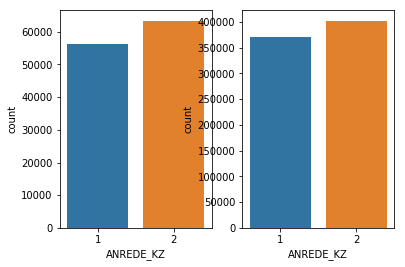

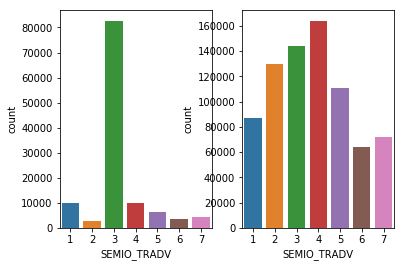

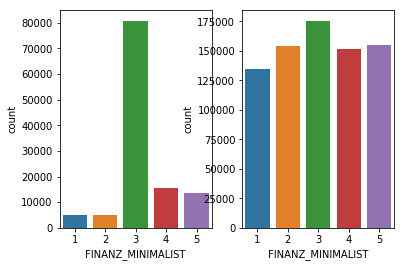

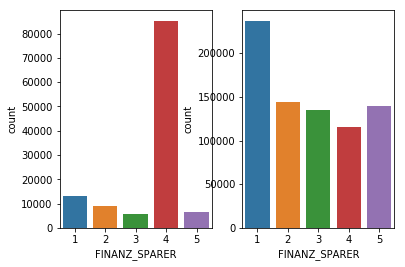

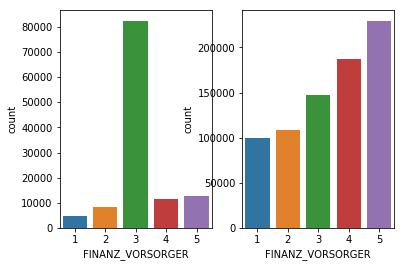

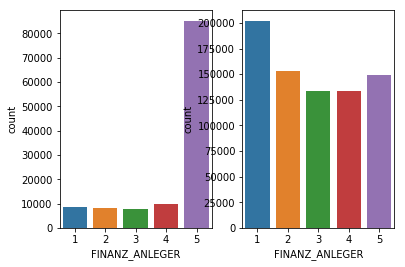

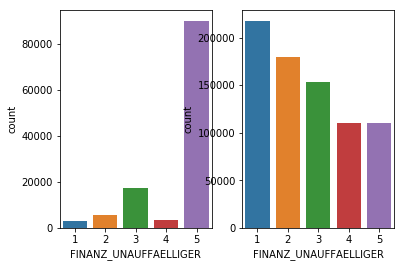

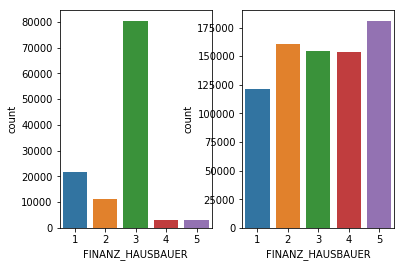

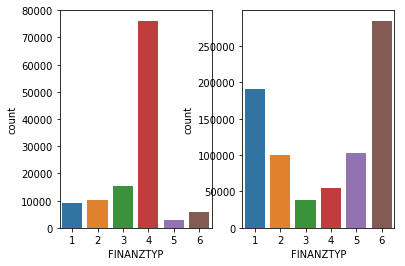

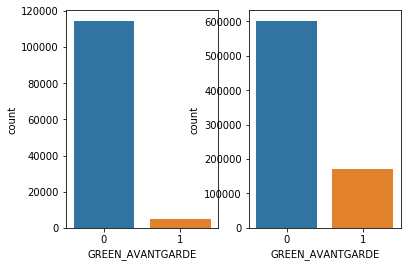

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
missing_data=count_missing_data(azdias_columns_dropped)
no_missing_list=missing_data[missing_data["nan [%]"]==0].head(10)["feature"].values.tolist()

for column in no_missing_list:
    fig, ax = plt.subplots(1,2)
    sns.countplot(azdias_nan_rows[column], ax=ax[0])
    sns.countplot(azdias_no_nan_rows[column], ax=ax[1])

#### Discussion 1.1.3: Assess Missing Data in Each Row

It seems like about 70% of the rows do not have any missing values at all.

Out of the remaining 30%, 16,6% have up to eight missing values per row and 13,4% more than eight, with noticeable clusters at 43 and 47 missing values per row, constituting about 8% of the total rows.

Ordered by sheer quantity the rows are mostly not effected by missing values (70%), little effected (16,6%), or next to void of data (8%), with very little in between (5,4%).

The comparison of ten randomly picked columns with no missing data between a dataset consisting of rows with up to eight missing data points per row and a dataset of rows with more than eight missing data points revealed a difference in the distribution of the values of those datasets.

While there seems to be next to no difference in "ANREDE_KZ" and a noticeable difference in "GREEN_AVANTGARDE", the differences in the other eight, randomly picked columns was far bigger, mostly showing a dominance of specific values in the rows with missing values, not seen in the rows without missing data. At first glance it also seems like the distribution of the other values would be pretty similar, would those dominant values be ignored.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?
feat_info["type"].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [12]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
def get_types(df):
    binary=[]
    binary_non_num=[]
    multi_level=[]
    categorical=feat_info[feat_info["type"]=="categorical"]["attribute"].values
    for column in categorical:
        if column in df.columns.values:
            if len(df[column].unique())==2:
                if isinstance(df[column].unique()[0], str):
                    binary_non_num.append(column)
                else:
                    binary.append(column)
            else:
                multi_level.append(column)

    return binary, binary_non_num, multi_level

In [21]:
binary, binary_non_num, multi_level=get_types(azdias_no_nan_rows)
print("The binary categoricals are: "+ str(binary))
print("The non numeric binary categorical is: "+ str(binary_non_num))
print("The multi-level categoricals are: "+str(multi_level))

The binary categoricals are: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ']
The non numeric binary categorical is: ['OST_WEST_KZ']
The multi-level categoricals are: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [22]:
categorical=feat_info[feat_info["type"]=="categorical"]["attribute"].values
for column in categorical:
    if column in azdias_no_nan_rows.columns.values:
        print(column+": "+str(azdias_no_nan_rows[column].unique()))

ANREDE_KZ: [2 1]
CJT_GESAMTTYP: [ 5.  3.  2.  4.  1.  6.]
FINANZTYP: [1 6 5 2 4 3]
GFK_URLAUBERTYP: [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.]
GREEN_AVANTGARDE: [0 1]
LP_FAMILIE_FEIN: [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB: [  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN: [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.]
LP_STATUS_GROB: [ 1.  2.  4.  5.  3.]
NATIONALITAET_KZ: [  1.   3.   2.  nan]
SHOPPER_TYP: [  3.   2.   1.   0.  nan]
SOHO_KZ: [ 1.  0.]
VERS_TYP: [  2.   1.  nan]
ZABEOTYP: [5 3 4 1 6 2]
GEBAEUDETYP: [ 8.  1.  3.  2.  6.  4.  5.]
OST_WEST_KZ: ['W' 'O']
CAMEO_DEUG_2015: ['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
CAMEO_DEU_2015: ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


In [13]:
# Re-encode categorical variable(s) to be kept in the analysis.
def change_to_num(df, columns):
    df_new=df
    for column in columns:
        variable_list=df[column].unique()
        if len(variable_list)==2:
            df_new[column]=df[column].replace(variable_list[0], 0)
            df_new[column]=df[column].replace(variable_list[1], 1)
        else:
            print("The columns "+ column+ " number of variables doesn't fit")
            
    return df_new


In [24]:
azdias_num=change_to_num(azdias_no_nan_rows, binary_non_num)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
# delete columns that seem to be redundant
red_cols=["CAMEO_DEUG_2015", "LP_FAMILIE_GROB", "LP_STATUS_GROB"]
azdias_no_red=azdias_num.drop(red_cols, axis=1)

In [26]:
multi_level_no_red=[col for col in multi_level if col not in red_cols]
azdia_one_hot=pd.get_dummies(azdias_no_red, columns=multi_level_no_red)

#### Discussion 1.2.1: Re-Encode Categorical Features

There seem to be 13 multi-level categoricals. After looking into the markdown file three seem to be redundant, as there are already versions of those categories with more details.

Those are:

-CAMEO_DEUG_2015, 

-LP_FAMILIE_GROB and

-LP_STATUS_GROB

The other ten were one hot encoded using pd.getdummies.

Also, the non numeric binary value was changed to a numeric one.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

1: 40s - war years (Mainstream, E+W)
2: 40s - reconstruction years (Avantgarde, E+W)
3: 50s - economic miracle (Mainstream, E+W)
4: 50s - milk bar / Individualisation (Avantgarde, E+W)
5: 60s - economic miracle (Mainstream, E+W)
6: 60s - generation 68 / student protestors (Avantgarde, W)
7: 60s - opponents to the building of the Wall (Avantgarde, E)
8: 70s - family orientation (Mainstream, E+W)
9: 70s - peace movement (Avantgarde, E+W)
10: 80s - Generation Golf (Mainstream, W)
11: 80s - ecological awareness (Avantgarde, W)
12: 80s - FDJ / communist party youth organisation (Mainstream, E)
13: 80s - Swords into ploughshares (Avantgarde, E)
14: 90s - digital media kids (Mainstream, E+W)
15: 90s - ecological awareness (Avantgarde, E+W)

In [14]:
def code_decade(row):
    if pd.isna(row["PRAEGENDE_JUGENDJAHRE"]):
        return row["PRAEGENDE_JUGENDJAHRE"]
    else:
        #40s
        if row["PRAEGENDE_JUGENDJAHRE"] in [1, 2]:
            return 1
        #50s
        elif row["PRAEGENDE_JUGENDJAHRE"] in [3, 4]:
            return 2
        #60s
        elif row["PRAEGENDE_JUGENDJAHRE"] in [5, 6, 7]:
            return 3
        #70s
        elif row["PRAEGENDE_JUGENDJAHRE"] in [8, 9]:
            return 4
        #80s
        elif row["PRAEGENDE_JUGENDJAHRE"] in [10, 11, 12, 13]:
            return 5
        #90s
        elif row["PRAEGENDE_JUGENDJAHRE"] in [14, 15]:
            return 6

In [15]:
def code_movement(row):
    if pd.isna(row["PRAEGENDE_JUGENDJAHRE"]):
        return row["PRAEGENDE_JUGENDJAHRE"]
    else:
        if row["PRAEGENDE_JUGENDJAHRE"] in [1, 3, 5, 8, 10, 12, 14]:
            return 1
        else:
            return 2

In [61]:
azdia_one_hot["decade"]=azdia_one_hot.apply(lambda row: code_decade(row), axis=1)
azdia_one_hot["movement"]=azdia_one_hot.apply(lambda row: code_movement(row), axis=1)

In [62]:
azdia_no_jugend=azdia_one_hot.drop("PRAEGENDE_JUGENDJAHRE", axis=1)

11: Wealthy Households - Pre-Family Couples & Singles
12: Wealthy Households - Young Couples With Children
13: Wealthy Households - Families With School Age Children
14: Wealthy Households - Older Families & Mature Couples
15: Wealthy Households - Elders In Retirement
21: Prosperous Households - Pre-Family Couples & Singles
22: Prosperous Households - Young Couples With Children
23: Prosperous Households - Families With School Age Children
24: Prosperous Households - Older Families & Mature Couples
25: Prosperous Households - Elders In Retirement
31: Comfortable Households - Pre-Family Couples & Singles
32: Comfortable Households - Young Couples With Children
33: Comfortable Households - Families With School Age Children
34: Comfortable Households - Older Families & Mature Couples
35: Comfortable Households - Elders In Retirement
41: Less Affluent Households - Pre-Family Couples & Singles
42: Less Affluent Households - Young Couples With Children
43: Less Affluent Households - Families With School Age Children
44: Less Affluent Households - Older Families & Mature Couples
45: Less Affluent Households - Elders In Retirement
51: Poorer Households - Pre-Family Couples & Singles
52: Poorer Households - Young Couples With Children
53: Poorer Households - Families With School Age Children
54: Poorer Households - Older Families & Mature Couples
55: Poorer Households - Elders In Retirement

In [16]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def code_wealth(row):
    if pd.isna(row["CAMEO_INTL_2015"]):
        return row["CAMEO_INTL_2015"]
    else:
        number=str(row["CAMEO_INTL_2015"])[0]
        return int(number)

In [17]:
def code_life_stage(row):
    if pd.isna(row["CAMEO_INTL_2015"]):
        return row["CAMEO_INTL_2015"]
    else:
        number=str(row["CAMEO_INTL_2015"])[1]
        return int(number)

In [65]:
azdia_no_jugend["wealth"]=azdia_no_jugend.apply(lambda row: code_wealth(row), axis=1)
azdia_no_jugend["life_stage"]=azdia_no_jugend.apply(lambda row: code_life_stage(row), axis=1)

In [66]:
azdia_wealth=azdia_no_jugend.drop("CAMEO_INTL_2015", axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I can't say theres anything to report about "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" other than, that I did what was told.

Regarding the other mixed values, I decided to delete "LP_LEBENSPHASE_GROB" and "LP_LEBENSPHASE_FEIN", as both seemed to be pretty redundand with the new column "life_stage" having pretty much the same information.

"KBA05_BAUMAX" got deleted in a previous step, as it had far to many missing values.

"Wohnlage" and "PLZ8_BAUMAX" have both been one hot encoded, as they are close to ordinal, but one or two of their values make them categorical.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [67]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdia_no_life=azdia_wealth.drop(["LP_LEBENSPHASE_GROB", "LP_LEBENSPHASE_FEIN"], axis=1)
remaining_mixed=["WOHNLAGE", "PLZ8_BAUMAX"]
azdia_one_hot_bau=pd.get_dummies(azdia_no_life, columns=remaining_mixed)

In [42]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [18]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df=replace_missing_values(df)
    
    # remove selected columns and rows, ...
    high_nan_list=['TITEL_KZ',
                    'AGER_TYP',
                    'KK_KUNDENTYP',
                    'KBA05_BAUMAX',
                    'GEBURTSJAHR',
                    'ALTER_HH']
    
    df=df.drop(high_nan_list, axis=1)
    df=df[df.isnull().sum(axis=1)<9]
    # select, re-encode, and engineer column values.
    binary, binary_non_num, multi_level=get_types(df)
    df=change_to_num(df, binary_non_num)
    
    red_cols=["CAMEO_DEUG_2015", "LP_FAMILIE_GROB", "LP_STATUS_GROB"]
    df=df.drop(red_cols, axis=1)
    multi_level_no_red=[col for col in multi_level if col not in red_cols]
    df=pd.get_dummies(df, columns=multi_level_no_red)
    
    df["decade"]=df.apply(lambda row: code_decade(row), axis=1)
    df["movement"]=df.apply(lambda row: code_movement(row), axis=1)
    df=df.drop("PRAEGENDE_JUGENDJAHRE", axis=1)
    
    df["wealth"]=df.apply(lambda row: code_wealth(row), axis=1)
    df["life_stage"]=df.apply(lambda row: code_life_stage(row), axis=1)
    
    df=df.drop("CAMEO_INTL_2015", axis=1)
    df=df.drop(["LP_LEBENSPHASE_GROB", "LP_LEBENSPHASE_FEIN"], axis=1)
    
    remaining_mixed=["WOHNLAGE", "PLZ8_BAUMAX"]
    df=pd.get_dummies(df, columns=remaining_mixed)
    # Return the cleaned dataframe.
    
    return df
    

In [19]:
azdia_one_hot_bau=clean_data(azdias)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [20]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer
imp=Imputer(strategy='most_frequent')
azdia_one_hot_bau=pd.DataFrame(imp.fit_transform(azdia_one_hot_bau), columns=azdia_one_hot_bau.columns.values)


In [21]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
azida_scal=scaler.fit_transform(azdia_one_hot_bau)

### Discussion 2.1: Apply Feature Scaling

I used the Imputer with "Most frequent". The other options would have been mean and median, which might have given some strange results on the categorical and ordinal values. Other than that I used the Standardscaler as suggested.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [22]:
from sklearn.decomposition import PCA

In [76]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azida_scal)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Total Variance: 1.0


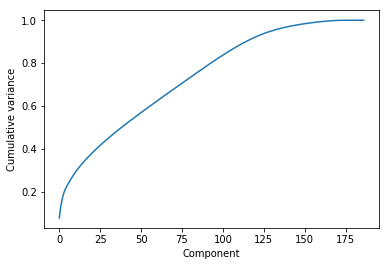

In [77]:
def plot_tot_var(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel("Component")
    plt.ylabel("Cumulative variance")
    print("Total Variance: "+ str(sum(pca.explained_variance_ratio_)))
    
plot_tot_var(pca)

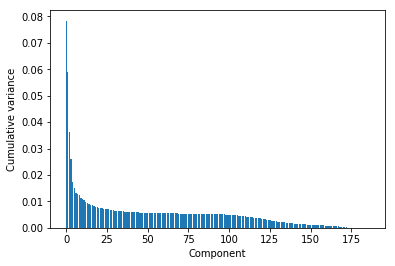

In [78]:
def plot_var(pca):
    comp_len=len(pca.explained_variance_ratio_)
    plt.bar(np.arange(comp_len), pca.explained_variance_ratio_)
    plt.xlabel("Component")
    plt.ylabel("Cumulative variance")

plot_var(pca)

In [23]:
# Re-apply PCA to the data while selecting for number of components to retain.
azida_pca = PCA(n_components=100)
X_pca=azida_pca.fit_transform(azida_scal)
print("Total Variance: "+ str(sum(azida_pca.explained_variance_ratio_)))

Total Variance: 0.828476236429


### Discussion 2.2: Perform Dimensionality Reduction

Judging by the plots, the first few components seem to hold most of the variance, with the first component having as much as 8% and the first 25% having nearly 50%. The variance values of the single components seem to be declining very slowly afterwards up until the 100th component, were the decline seems to escalate again.

At that point 82,8% of the total variance has been reached, with every additional component contributing less and less. This is the reason why I have choosen 100 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [91]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def show_weights(df, pca, i):
    i-=1
    col_num=len(df.columns)
    com_num=len(pca.components_[i])
    comp_one=pca.components_[i].reshape(com_num, 1)
    weights_df=pd.DataFrame(comp_one, index=df.columns, columns=["Weight"])
    weights_df.sort_values("Weight", ascending=False, inplace=True)
    print(weights_df.head(5))
    print(weights_df.tail(5))

In [92]:
show_weights(azdia_one_hot_bau, azida_pca, 1)

                      Weight
PLZ8_ANTG3          0.195111
PLZ8_ANTG4          0.188086
wealth              0.182264
HH_EINKOMMEN_SCORE  0.180137
ORTSGR_KLS9         0.170299
                     Weight
KBA05_ANTG1       -0.186455
PLZ8_BAUMAX_1.0   -0.188931
FINANZ_MINIMALIST -0.189869
PLZ8_ANTG1        -0.195333
MOBI_REGIO        -0.196910


In [1]:
from IPython.display import Markdown, display

display(Markdown("Data_Dictionary.md"))

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level features
 7. RR1 neighborhood features
 8. PLZ8 macro-cell features
 9. Community-level features

-----

## 1. Person-level features

### 1.1. AGER_TYP
Best-ager typology
- -1: unknown
-  0: no classification possible
-  1: passive elderly
-  2: cultural elderly
-  3: experience-driven elderly

### 1.2. ALTERSKATEGORIE_GROB
Estimated age based on given name analysis
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: < 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: > 60 years old
-  9: uniformly distributed

### 1.3. ANREDE_KZ
Gender
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: male
-  2: female

### 1.4. CJT_GESAMTTYP
Customer-Journey-Typology: preferred information and buying channels for
consumer
- 0: unknown
- 1: Advertising- and Consumptionminimalist
- 2: Advertising- and Consumptiontraditionalist
- 3: advertisinginterested Store-shopper
- 4: advertisinginterested Online-shopper
- 5: Advertising- and Cross-Channel-Enthusiast
- 6: Advertising-Enthusiast with restricted Cross-Channel-Behaviour

### 1.5. FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER,
###      FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER
Financial typology, for each dimension:
- -1: unknown
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low

Dimension translations:
- MINIMALIST: low financial interest
- SPARER: money-saver
- VORSORGER: be prepared
- ANLEGER: investor
- UNAUFFAELLIGER: inconspicuous
- HAUSBAUER: home ownership

### 1.6. FINANZTYP
Most descriptive financial type for individual
- -1: unknown
-  1: low financial interest (MINIMALIST)
-  2: money-saver (SPARER)
-  3: home ownership (HAUSBAUER)
-  4: be prepared (VORSORGER)
-  5: investor (ANLEGER)
-  6: inconspicuous (UNAUFFAELLIGER)

### 1.7. GEBURTSJAHR
Year of birth
- missing data encoded as 0

### 1.8. GFK_URLAUBERTYP
Vacation habits
-  1: Event travelers
-  2: Family-oriented vacationists
-  3: Winter sportspeople
-  4: Culture lovers
-  5: Nature fans
-  6: Hiker
-  7: Golden ager
-  8: Homeland-connected vacationists
-  9: Package tour travelers
- 10: Connoisseurs
- 11: Active families
- 12: Without vacation

### 1.9. GREEN_AVANTGARDE
Membership in environmental sustainability as part of youth
- 0: not a member of green avantgarde
- 1: member of green avantgarde

### 1.10. HEALTH_TYP
Health typology
- -1: unknown
-  0: classification not possible
-  1: critical reserved
-  2: sanitary affine  
-  3: jaunty hedonists

### 1.11. LP_LEBENSPHASE_FEIN
Life stage, fine scale
-  1: single low-income earners of younger age
-  2: single low-income earners of middle age
-  3: single average earners of younger age
-  4: single average earners of middle age
-  5: single low-income earners of advanced age
-  6: single low-income earners at retirement age
-  7: single average earners of advanced age
-  8: single average earners at retirement age
-  9: single independent persons
- 10: wealthy single homeowners
- 11: single homeowners of advanced age
- 12: single homeowners at retirement age
- 13: single top earners of higher age
- 14: low-income and average earner couples of younger age
- 15: low-income earner couples of higher age
- 16: average earner couples of higher age
- 17: independent couples
- 18: wealthy homeowner couples of younger age
- 19: homeowner couples of higher age
- 20: top earner couples of higher age
- 21: single parent low-income earners
- 22: single parent average earners
- 23: single parent high-income earners
- 24: low-income earner families
- 25: average earner families
- 26: independent families
- 27: homeowner families
- 28: top earner families
- 29: low-income earners of younger age from multiperson households
- 30: average earners of younger age from multiperson households
- 31: low-income earners of higher age from multiperson households
- 32: average earners of higher age from multiperson households
- 33: independent persons of younger age from multiperson households
- 34: homeowners of younger age from multiperson households
- 35: top earners of younger age from multiperson households
- 36: independent persons of higher age from multiperson households
- 37: homeowners of advanced age from multiperson households
- 38: homeowners at retirement age from multiperson households
- 39: top earners of middle age from multiperson households
- 40: top earners at retirement age from multiperson households

### 1.12. LP_LEBENSPHASE_GROB
Life stage, rough scale
-  1: single low-income and average earners of younger age
-  2: single low-income and average earners of higher age
-  3: single high-income earners
-  4: single low-income and average-earner couples
-  5: single high-income earner couples
-  6: single parents
-  7: single low-income and average earner families
-  8: high-income earner families
-  9: average earners of younger age from multiperson households
- 10: low-income and average earners of higher age from multiperson households
- 11: high-income earners of younger age from multiperson households
- 12: high-income earners of higher age from multiperson households

### 1.13. LP_FAMILIE_FEIN
Family type, fine scale
-  0: unknown
-  1: single
-  2: couple
-  3: young single parent
-  4: single parent with teenager
-  5: single parent with child of full age
-  6: young family
-  7: family with teenager
-  8: family with child of full age
-  9: shared flat
- 10: two-generational household
- 11: multi-generational household

### 1.14. LP_FAMILIE_GROB
Family type, rough scale
- 0: unknown
- 1: single (maps to 1 in fine scale)
- 2: couple (maps to 2 in fine scale)
- 3: single parent (maps to 3-5 in fine scale)
- 4: family (maps to 6-8 in fine scale)
- 5: multiperson household (maps to 9-11 in fine scale)

### 1.15. LP_STATUS_FEIN
Social status, fine scale
-  1: typical low-income earners
-  2: orientation-seeking low-income earners
-  3: aspiring low-income earners
-  4: villagers
-  5: minimalistic high-income earners
-  6: independent workers
-  7: title holder-households
-  8: new houseowners
-  9: houseowners
- 10: top earners

### 1.16. LP_STATUS_GROB
Social status, rough scale
- 1: low-income earners (maps to 1-2 in fine scale)
- 2: average earners (maps to 3-5 in fine scale)
- 3: independents (maps to 6-7 in fine scale)
- 4: houseowners (maps to 8-9 in fine scale)
- 5: top earners (maps to 10 in fine scale)

### 1.17. NATIONALITAET_KZ
Nationality based on given name analysis
- -1: unknown
-  0: unknown
-  1: German-sounding
-  2: foreign-sounding
-  3: assimilated names

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

### 1.19. RETOURTYP_BK_S
Return type
- 0: unknown
- 1: influenceable Crazy-Shopper
- 2: demanding Heavy-Returner
- 3: incentive-receptive Normal-Returner
- 4: conservative Low-Returner
- 5: determined Minimal-Returner

### 1.20. SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST,
###       SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM,
###       SEMIO_PFLICHT, SEMIO_TRADV
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

Dimension translations:
- SOZ: socially-minded
- FAM: family-minded
- REL: religious
- MAT: materialistic
- VERT: dreamful
- LUST: sensual-minded
- ERL: event-oriented
- KULT: cultural-minded
- RAT: rational
- KRIT: critical-minded
- DOM: dominant-minded
- KAEM: combative attitude
- PFLICHT: dutiful
- TRADV: tradional-minded

### 1.21. SHOPPER_TYP
Shopper typology
- -1: unknown
-  0: external supplied hedonists
-  1: Shopping-stressed
-  2: family-shopper
-  3: demanding shopper

### 1.22. SOHO_KZ
Small office / home office flag
- -1: unknown
- 0: no small office/home office
- 1: small office/home office

### 1.23. TITEL_KZ
Academic title flag
- -1: unknown
-  0: unknown
-  1: Dr.
-  2: Dr. Dr.
-  3: Prof.
-  4: Prof. Dr.
-  5: other

### 1.24. VERS_TYP
Insurance typology
- -1: unknown
-  1: social-safety driven
-  2: individualistic-accepting risks

### 1.25. ZABEOTYP
Energy consumption typology
- -1: unknown
-  1: green
-  2: smart
-  3: fair supplied
-  4: price driven
-  5: seeking orientation
-  6: indifferent
-  9: unknown

-----

## 2. Household-level features

### 2.1. ALTER_HH
Birthdate of head of household
-  0: unknown / no main age detectable
-  1: 1895-01-01 to 1899-12-31
-  2: 1900-01-01 to 1904-12-31
-  3: 1905-01-01 to 1909-12-31
-  4: 1910-01-01 to 1914-12-31
-  5: 1915-01-01 to 1919-12-31
-  6: 1920-01-01 to 1924-12-31
-  7: 1925-01-01 to 1929-12-31
-  8: 1930-01-01 to 1934-12-31
-  9: 1935-01-01 to 1939-12-31
- 10: 1940-01-01 to 1944-12-31
- 11: 1945-01-01 to 1949-12-31
- 12: 1950-01-01 to 1954-12-31
- 13: 1955-01-01 to 1959-12-31
- 14: 1960-01-01 to 1964-12-31
- 15: 1965-01-01 to 1969-12-31
- 16: 1970-01-01 to 1974-12-31
- 17: 1975-01-01 to 1979-12-31
- 18: 1980-01-01 to 1984-12-31
- 19: 1985-01-01 to 1989-12-31
- 20: 1990-01-01 to 1994-12-31
- 21: 1995-01-01 to 1999-12-31

### 2.2. ANZ_PERSONEN
Number of adults in household

### 2.3. ANZ_TITEL
Number of professional academic title holders in household

### 2.4. HH_EINKOMMEN_SCORE
Estimated household net income
- -1: unknown
-  0: unknown
-  1: highest income
-  2: very high income
-  3: high income
-  4: average income
-  5: lower income
-  6: very low income

### 2.5. KK_KUNDENTYP
Consumer pattern over past 12 months
- -1: unknown
-  1: regular customer
-  2: active customer
-  3: new costumer
-  4: stray customer
-  5: inactive customer
-  6: passive customer

### 2.6. W_KEIT_KIND_HH
Likelihood of children in household
- -1: unknown
-  0: unknown
-  1: most likely
-  2: very likely
-  3: likely
-  4: average
-  5: unlikely
-  6: very unlikely

### 2.7. WOHNDAUER_2008
Length of residence
- -1: unknown
-  0: unknown
-  1: length of residence less than 1 year
-  2: length of residence 1-2 years
-  3: length of residence 2-3 years
-  4: length of residence 3-4 years
-  5: length of residence 4-5 years
-  6: length of residence 5-6 years
-  7: length of residence 6-7 years
-  8: length of residence 7-10 years
-  9: length of residence more than 10 years

-----

## 3. Building-level features

### 3.1. ANZ_HAUSHALTE_AKTIV
Number of households in the building
- missing values encoded by 0

### 3.2. ANZ_HH_TITEL
Number of professional academic title holders in building

### 3.3. GEBAEUDETYP
Type of building (residential vs. commercial)
- -1: unknown
-  0: unknown
-  1: residential building
-  2: residential building buildings without actually known household
-  3: mixed (=residential and company) building
-  4: mixed building without actually known household or company
-  5: company building w/o known company
-  6: mixed building without actually known household
-  7: company building
-  8: mixed building without actually known company

### 3.4. KONSUMNAEHE
Distance from building to point of sale (PoS)
- 1: building is located in a 125 x 125m grid cell (RA1), which is a
     consumption cell
- 2: building is located in a 250 x 250m grid cell that includes at least one
     RA1-consumption cell
- 3: building is located in a 500 x 500m grid cell that includes at least one
     RA1-consumption cell
- 4: building is located in a 1 x 1km grid cell that includes at least one
     RA1-consumption cell
- 5: building is located in a 2 x 2km grid cell that includes at least one
     RA1-consumption cell
- 6: building is located in a 10 x 10km grid cell that includes at least one
     RA1-consumption cell
- 7: building is not located in a 10 x 10km range of a consumption cell

### 3.5. MIN_GEBAEUDEJAHR
First year building was mentioned in the database
- missing values encoded by 0

### 3.6. OST_WEST_KZ
Building location via former East / West Germany (GDR / FRG)
- -1: unknown
-  O: East (GDR)
-  W: West (FRG)

### 3.7. WOHNLAGE
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

-----

## 4. RR4 micro-cell features

### 4.1. CAMEO_DEUG_2015
German CAMEO: Wealth / Life Stage Typology, rough scale
- -1: unknown
-  1: upper class
-  2: upper middleclass
-  3: established middleclass
-  4: consumption-oriented middleclass
-  5: active middleclass
-  6: low-consumption middleclass
-  7: lower middleclass
-  8: working class
-  9: urban working class
-  X: unknown

### 4.2. CAMEO_DEU_2015
German CAMEO: Wealth / Life Stage Typology, detailed scale
- 1A: Work-Life-Balance
- 1B: Wealthy Best Ager
- 1C: Successful Songwriter
- 1D: Old Nobility
- 1E: City Nobility
- 2A: Cottage Chic
- 2B: Noble Jogger
- 2C: Established gourmet
- 2D: Fine Management
- 3A: Career & Family
- 3B: Powershopping Families
- 3C: Rural Neighborhood
- 3D: Secure Retirement
- 4A: Family Starter
- 4B: Family Life
- 4C: String Trimmer
- 4D: Empty Nest
- 4E: Golden Ager
- 5A: Younger Employees
- 5B: Suddenly Family
- 5C: Family First
- 5D: Stock Market Junkies
- 5E: Coffee Rider
- 5F: Active Retirement
- 6A: Jobstarter
- 6B: Petty Bourgeois
- 6C: Long-established
- 6D: Sportgardener
- 6E: Urban Parents
- 6F: Frugal Aging
- 7A: Journeymen
- 7B: Mantaplatte
- 7C: Factory Worker
- 7D: Rear Window
- 7E: Interested Retirees
- 8A: Multi-culteral
- 8B: Young & Mobile
- 8C: Prefab
- 8D: Town Seniors
- 9A: First Shared Apartment
- 9B: Temporary Workers
- 9C: Afternoon Talk Show
- 9D: Mini-Jobber
- 9E: Socking Away
- XX: unknown

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

-----

## 5. RR3 micro-cell features

### 5.1. KBA05_ANTG1
Number of 1-2 family houses in the microcell
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes

### 5.2. KBA05_ANTG2
Number of 3-5 family houses in the microcell
- -1: unknown
-  0: no 3-5 family homes
-  1: lower share of 3-5 family homes
-  2: average share of 3-5 family homes
-  3: high share of 3-5 family homes
-  4: very high share of 3-5 family homes

### 5.3. KBA05_ANTG3
Number of 6-10 family houses in the microcell
- -1: unknown
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes

### 5.4. KBA05_ANTG4
Number of 10+ family houses in the microcell
- -1: unknown
-  0: no 10+ family homes
-  1: lower share of 10+ family homes
-  2: high share of 10+ family homes

### 5.5. KBA05_BAUMAX
Most common building type within the microcell
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes in the microcell
-  2: mainly 3-5 family homes in the microcell
-  3: mainly 6-10 family homes in the microcell
-  4: mainly 10+ family homes in the microcell
-  5: mainly business buildings in the microcell

### 5.6. KBA05_GBZ
Number of buildings in the microcell
- -1: unknown
-  0: unknown
-  1: 1-2 buildings
-  2: 3-4 buildings
-  3: 5-16 buildings
-  4: 17-22 buildings
-  5: >=23 buildings

-----

## 6. Postcode-level features

### 6.1. BALLRAUM
Distance to nearest urban center
- -1: unknown
-  1: less than 10 km
-  2: 10 -  20 km
-  3: 20 -  30 km
-  4: 30 -  40 km
-  5: 40 -  50 km
-  6: 50 - 100 km
-  7: more than 100 km

### 6.2. EWDICHTE
Density of households per square kilometer
- -1: unknown
-  1: less than 34 households per km^2
-  2:  34 -  89 households per km^2
-  3:  90 - 149 households per km^2
-  4: 150 - 319 households per km^2
-  5: 320 - 999 households per km^2
-  6: more than 999 households per km^2

### 6.3. INNENSTADT
Distance to city center (downtown)
- -1: unknown
-  1: in city center
-  2: less than 3 km to city center
-  3:  3 -  5 km to city center
-  4:  5 - 10 km to city center
-  5: 10 - 20 km to city center
-  6: 20 - 30 km to city center
-  7: 30 - 40 km to city center
-  8: more than 40 km to city center

-----

## 7. RR1 region features

### 7.1. GEBAEUDETYP_RASTER
Ratio of residential to commercial activity
- 1: business cell
- 2: mixed cell with high business share
- 3: mixed cell with middle business share
- 4: mixed cell with low business share
- 5: residential cell

### 7.2. KKK
Purchasing power in region
- -1; unknown
-  0: unknown
-  1: very high
-  2: high
-  3: average
-  4: low

### 7.3. MOBI_REGIO
Movement patterns
- 1: very high movement
- 2: high movement
- 3: middle movement
- 4: low movement
- 5: very low movement
- 6: none

### 7.4. ONLINE_AFFINITAET
Online affinity
- 0: none
- 1: low
- 2: middle
- 3: high
- 4: very high
- 5: highest

### 7.5. REGIOTYP
Neighborhood typology
- -1: unknown
-  0: unknown
-  1: upper class
-  2: conservatives
-  3: upper middle class
-  4: middle class
-  5: lower middle class
-  6: traditional workers
-  7: marginal groups

-----

## 8. PLZ8 macro-cell features

### 8.1. KBA13_ANZAHL_PKW
Number of cars in the PLZ8 region

### 8.2. PLZ8_ANTG1
Number of 1-2 family houses in the PLZ8 region
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes

### 8.3. PLZ8_ANTG2
Number of 3-5 family houses in the PLZ8 region
- -1: unknown
-  0: no 3-5 family homes
-  1: lower share of 3-5 family homes
-  2: average share of 3-5 family homes
-  3: high share of 3-5 family homes
-  4: very high share of 3-5 family homes

### 8.4. PLZ8_ANTG3
Number of 6-10 family houses in the PLZ8 region
- -1: unknown
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes

### 8.5. PLZ8_ANTG4
Number of 10+ family houses in the PLZ8 region
- -1: unknown
-  0: no 10+ family homes
-  1: lower share of 10+ family homes
-  2: high share of 10+ family homes

### 8.6. PLZ8_BAUMAX
Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings

### 8.7. PLZ8_HHZ
Number of households within the PLZ8 region
- -1: unknown
-  1: less than 130 households
-  2: 131-299 households
-  3: 300-599 households
-  4: 600-849 households
-  5: more than 849 households

### 8.8. PLZ8_GBZ
Number of buildings within the PLZ8 region
- -1: unknown
-  1: less than 60 buildings
-  2:  60-129 buildings
-  3: 130-299 buildings
-  4: 300-449 buildings
-  5: more than 449 buildings

-----

## 9. Community-level features

### 9.1. ARBEIT
Share of unemployment in community
- -1: unknown
-  1: very low
-  2: low
-  3: average
-  4: high
-  5: very high
-  9: unknown

### 9.2. ORTSGR_KLS9
Size of community
- -1: unknown
-  1: <= 2,000 inhabitants
-  2:   2,001 to   5,000 inhabitants
-  3:   5,001 to  10,000 inhabitants
-  4:  10,001 to  20,000 inhabitants
-  5:  20,001 to  50,000 inhabitants
-  6:  50,001 to 100,000 inhabitants
-  7: 100,001 to 300,000 inhabitants
-  8: 300,001 to 700,000 inhabitants
-  9: > 700,000  inhabitants

### 9.3. RELAT_AB
Share of unemployment relative to county in which community is contained
- -1: unknown
-  1: very low
-  2: low
-  3: average
-  4: high
-  5: very high
-  9: unknown


In [93]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
show_weights(azdia_one_hot_bau, azida_pca, 2)


                        Weight
ALTERSKATEGORIE_GROB  0.233121
FINANZ_VORSORGER      0.218499
ZABEOTYP_3            0.198666
SEMIO_ERL             0.181501
SEMIO_LUST            0.162574
                         Weight
SEMIO_TRADV           -0.208319
FINANZ_UNAUFFAELLIGER -0.215143
SEMIO_REL             -0.217345
FINANZ_SPARER         -0.226737
decade                -0.230693


In [94]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
show_weights(azdia_one_hot_bau, azida_pca, 3)


                     Weight
SEMIO_VERT         0.323276
SEMIO_FAM          0.258762
SEMIO_SOZ          0.257651
SEMIO_KULT         0.249106
FINANZ_MINIMALIST  0.137701
              Weight
SEMIO_ERL  -0.206017
SEMIO_KRIT -0.267204
SEMIO_DOM  -0.284643
SEMIO_KAEM -0.318333
ANREDE_KZ  -0.347245


### Discussion 2.3: Interpret Principal Components

The first three principal components have been:

**First component**

Those people tend to life in regions with many big family homes (pos:PLZ8_ANTG3, PLZ8_ANTG4, neg: PLZ8_BAUMAX_1.0, KBA05_ANTG1, KBA05_ANTG1) and many inhabitants to begin with (ORTSGR_KLS9), which might indicate a place with a high density of customers and good infrastructure. They also seem to be poorer (pos: wealth, HH_EINKOMMEN_SCORE, neg: FINANZ_MINIMALIST) and move a lot (MOBI_REGIO), so they might not be as interested in mail orders, as they aren't as dependent to them, as someone stationary. Sounds like people working in lower income jobs of metropolitan areas. All in all, not the most ideal customers.

**Second component**

Those people seem to be older (ALTERSKATEGORIE_GROB, neg. decade), don't save for their retirement (FINANZ_VORSORGER), but save money nevertheless (FINANZ_SPARER) and pay attention to their energy supply (ZABEOTYP_3). They are also less interested in events (SEMIO_ERL) and sensual things (SEMIO_LUST) and are more conservative (SEMIO_PFLICHT, SEMIO_REL). Sounds like typical old people. Probably not great customers as well, but them being old and therefore less mobil could make them potential customers for essential wares.

**Third component**

Those people seem to be investors (FINANZTYP_5), male (ANREDE_KZ) and less interested in family, social and cultural topics (SEMIO_FAM, SEMIO_SOZ, SEMIO_KULT). They also seem to be dead inside (SEMIO_VERT). They are however event oriented, critical, combative and dominant (SEMIO_ERL, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM). Looks like the clichee of a macho man.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [24]:
from sklearn.cluster import KMeans

In [142]:
# Over a number of different cluster counts...
score_val=[]
for n in range(1,40,4):
    print(n)
    kmeans=KMeans(n_clusters=n)

    # run k-means clustering on the data and...
    model=kmeans.fit(X_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(X_pca))
    
    score_val.append(score)

1
5
9
13
17
21
25
29
33
37


In [145]:
score_val_2=[]
for n in range(6,10):
    print(n)
    kmeans=KMeans(n_clusters=n)

    # run k-means clustering on the data and...
    model=kmeans.fit(X_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(X_pca))
    
    score_val_2.append(score)

6
7
8
9


In [159]:
score_val_3=[]
for n in range(1,100, 10):
    print(n)
    kmeans=KMeans(n_clusters=n)

    # run k-means clustering on the data and...
    model=kmeans.fit(X_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(X_pca))
    
    score_val_3.append(score)

1
11
21
31
41
51
61
71
81
91


In [23]:
score_val_4=[]
for n in range(60,81, 4):
    print(n)
    kmeans=KMeans(n_clusters=n)

    # run k-means clustering on the data and...
    model=kmeans.fit(X_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(X_pca))
    
    score_val_4.append(score)

60
64
68
72
76
80


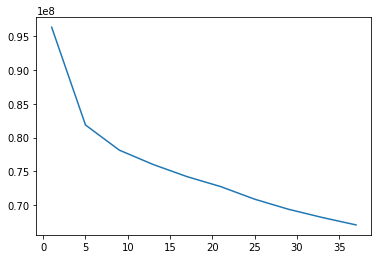

In [144]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(range(1,41,4), score_val)

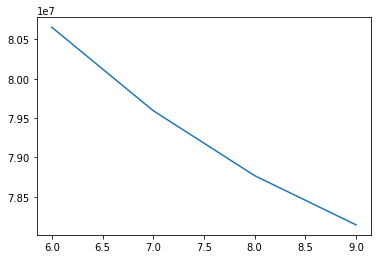

In [146]:
plt.plot(range(6,10,1), score_val_2)

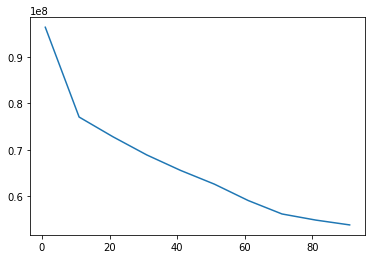

In [160]:
plt.plot(range(1,100,10), score_val_3)

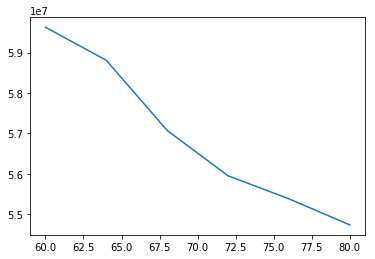

In [24]:
plt.plot(range(60,81, 4), score_val_4)

In [25]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans=KMeans(n_clusters=8)
model_az=kmeans.fit(X_pca)
azdias_pred=model_az.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

Judging by the plots, there are multiple areas that could be interpreteted as elbows, namely around 4, 8 and 72.

Since 72 seems to be far too large, I'm going to continue with 8.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [26]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")

In [27]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean=clean_data(customers)

#GEBAEUDETYP_5.0 is missing, probably because those values
#were not present in the data while encoding and have to be added to get
#the right shape
customers_len=customers_clean.shape[0]
customers_clean.reset_index(drop=True, inplace=True)
for column in azdia_one_hot_bau.columns:
    if column not in customers_clean.columns:
        customers_clean[column]=pd.Series([0]*customers_len)
        
customers_imp=pd.DataFrame(imp.fit_transform(customers_clean), columns=customers_clean.columns.values)
customers_scal=scaler.transform(customers_imp)
customers_pca=azida_pca.transform(customers_scal)
customers_pred=model_az.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [28]:
azdias_count=np.unique(azdias_pred, return_counts=True)
customers_count=np.unique(customers_pred, return_counts=True)

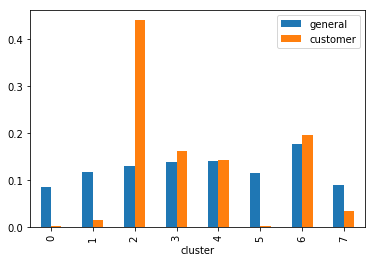

In [34]:
rel_df=pd.DataFrame({"cluster":azdias_count[0], "general":azdias_count[1]/sum(azdias_count[1]), "customer":customers_count[1]/sum(customers_count[1])})
rel_df.plot(x="cluster", y=["general", "customer"],kind="bar")

In [29]:
def rel_occurance_customer(general_pred, specific_pred):
    unique_general, count_general = np.unique(general_pred, return_counts=True)
    count_general_norm=count_general/len(general_pred)
    
    general_df=pd.DataFrame({"general": count_general_norm}, index=unique_general)
    
    unique_specific, count_specific = np.unique(specific_pred, return_counts=True)
    count_specific_norm=count_specific/len(specific_pred)
    
    specific_df=pd.DataFrame({"specific": count_specific_norm}, index=unique_specific)
    
    occ_df=general_df.join(specific_df)
    
    occ_df.fillna(0, inplace=True)
    
    occ_series=occ_df.apply(lambda row: row["specific"]/row["general"], axis=1)
    
    occ_series.sort_values(ascending=False, inplace=True)
    
    return occ_series

occ_series=rel_occurance_customer(azdias_pred, customers_pred)

In [33]:
occ_series.head()

2    3.347825
3    1.178273
6    1.107554
4    1.006662
7    0.396824
dtype: float64

In [32]:
occ_series.tail()

4    1.006662
7    0.396824
1    0.129241
5    0.032378
0    0.029239
dtype: float64

In [30]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
def show_customer(rank):
    overrep_num=occ_series.index[rank]
    cluster_overrep=scaler.inverse_transform(azida_pca.inverse_transform(model_az.cluster_centers_[overrep_num]))

    cluster_overrep_df=pd.DataFrame({"weight":cluster_overrep}, index=azdia_one_hot_bau.columns)
    cluster_overrep_df.sort_values("weight", inplace=True, ascending=False)
    print("Group "+ str(overrep_num))
    print(cluster_overrep_df.head(10))
    print(cluster_overrep_df.tail(10))
          
show_customer(0)

Group 2
                        weight
MIN_GEBAEUDEJAHR   1992.859135
KBA13_ANZAHL_PKW    700.622352
WOHNDAUER_2008        8.536025
ORTSGR_KLS9           5.331971
SEMIO_LUST            5.274740
SEMIO_ERL             5.222257
SEMIO_DOM             4.712145
SEMIO_VERT            4.694325
INNENSTADT            4.663308
FINANZ_MINIMALIST     4.507139
                      weight
CAMEO_DEU_2015_7D   0.001925
GEBAEUDETYP_4.0     0.001746
GEBAEUDETYP_6.0     0.000770
FINANZTYP_4         0.000184
GEBAEUDETYP_5.0    -0.000006
CAMEO_DEU_2015_9E  -0.000913
WOHNLAGE_0.0       -0.002010
CAMEO_DEU_2015_9C  -0.002443
LP_STATUS_FEIN_2.0 -0.013277
ZABEOTYP_5         -0.019170


In [31]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
show_customer(-1)

Group 0
                          weight
MIN_GEBAEUDEJAHR     1992.459043
KBA13_ANZAHL_PKW      538.281764
ANZ_HAUSHALTE_AKTIV    15.526283
WOHNDAUER_2008          7.100438
ORTSGR_KLS9             6.788196
SEMIO_KULT              6.782153
SEMIO_FAM               6.705373
SEMIO_SOZ               6.490947
SEMIO_REL               6.169005
SEMIO_VERT              6.036430
                      weight
GEBAEUDETYP_6.0    -0.000482
CAMEO_DEU_2015_3B  -0.000589
ZABEOTYP_2         -0.000687
CAMEO_DEU_2015_2C  -0.001042
WOHNLAGE_0.0       -0.001635
FINANZTYP_2        -0.002811
GEBAEUDETYP_2.0    -0.003497
CAMEO_DEU_2015_2A  -0.004546
LP_STATUS_FEIN_9.0 -0.006605
CJT_GESAMTTYP_2.0  -0.008853


### Discussion 3.3: Compare Customer Data to Demographics Data

First of all "MIN_GEBAEUDEJAHR" seems to be weighted **way** to high in those groups, as does the number of cars.

Out of the eight groups three are overrepresented and five underrepresented in the customer data, compared to the general data, although there is no group that is not represented at all.

**Group 2**
This group is the most overrepresented, being 3,35 times more numerous than it should be, compared to the general data.

This group doesn't move their household often ("WOHNDAUER_2008"), lives in bigger communities ("ORTSGR_KLS9"), but far away from city centers ("INNENSTADT") and doesn't seem to be financially interested ("FINANZ_MINIMALIST").
They are also neither dominant (SEMIO_DOM), dreamful (SEMIO_VERT), event-oriented (SEMIO_ERL) nor sensual (SEMIO_LUST).

Those people seem to rather dull, probably on the poorer side and might have to use the service, as they can't get into the city centers easily.

**Group 0**
This group it the least represented, being about 33 times more likely to be found in the general population.

This group lives in buildings with many households ("ANZ_HAUSHALTE_AKTIV") and tends to move seldom as well ("WOHNDAUER_2008"). They do also live in bigger communities ("ORTSGR_KLS9") and are neither cultural ("SEMIO_KULT"), family oriented ("SEMIO_FAM"), social ("SEMIO_SOZ"), religios ("SEMIO_REL") or dreamful ("SEMIO_VERT").

Their main difference seems to be, that their character is the exact opposite in what they are **not**.
Other than that, it seems to boil down to living close to the city center or not, as they seem to be pretty similar in the other aspects.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.